# **Predicting Ball Drawing After Punt**



In this notebook, we would like to build a model based on data-driven strategy to predict the results of a ball drawn after a punt. Because as we all know that an important role of coaches, in any sport, is predicting what the opposing team will do. Nobody can predict it perfectly, but the best coaches make good adjustments. Coaches and players can collaborate in each other to understand certain tendencies, and our objective is to take a data-driven approach in finding these.


**Overall Architecture**

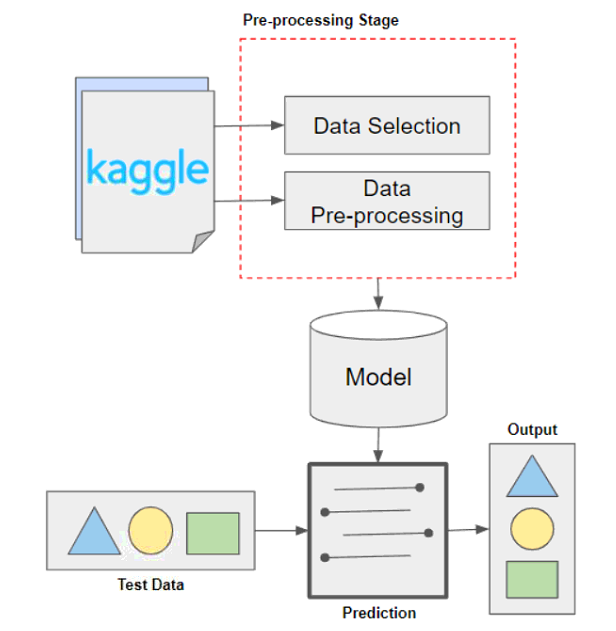



In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

Load **plays.csv** data using DataFrame from pandas library

In [ ]:
plays_df = pd.read_csv('../input/nfl-big-data-bowl-2022/plays.csv')
plays_df

In [ ]:
result_df = plays_df.groupby(['specialTeamsResult']).size().to_frame(name = 'count').reset_index()
result_df

In [ ]:
import plotly.express as px

fig = px.pie(result_df, values='count', names='specialTeamsResult', 
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [ ]:
import plotly.express as px

result_df = result_df.sort_values(by=['count'], ascending=False)
fig = px.bar(result_df, y='count', x='specialTeamsResult', text='count', log_y=False,
            color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [ ]:
plays_df.columns

Load **PFFScoutingData.csv** data using DataFrame from pandas library

In [ ]:
PFF_df = pd.read_csv('../input/nfl-big-data-bowl-2022/PFFScoutingData.csv')
PFF_df.columns

In [ ]:
X1 = plays_df[['gameId', 'playId', 'kickerId', 'specialTeamsPlayType', 'specialTeamsResult', 
              'yardlineNumber', 'kickLength', 'kickReturnYardage', 'playResult', 
              'absoluteYardlineNumber']].copy().set_index(['gameId', 'playId'])
X1

In [ ]:
X2 = PFF_df[['gameId', 'playId', 'snapDetail', 'kickType', 'kickContactType', 
              'operationTime', 'hangTime']].copy().set_index(['gameId', 'playId'])
X2

In [ ]:
X = pd.concat([X1, X2.reindex(X1.index)], axis=1)
X

In [ ]:
X_punt = X[X['specialTeamsPlayType'] == 'Punt']
X_punt

In [ ]:
X_punt.specialTeamsResult.value_counts()

In [ ]:
import plotly.express as px

result_df = X_punt.groupby(['specialTeamsResult']).size().to_frame(name = 'count').reset_index()
result_df

result_df = result_df.sort_values(by=['count'], ascending=False)
fig = px.bar(result_df, y='count', x='specialTeamsResult', text='count', log_y=False,
            color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [ ]:
X_punt = X_punt.dropna(subset=['kickType', 'kickContactType', 'snapDetail'])
X_punt

In [ ]:
X_punt['kickReturnYardage'] = X_punt['kickReturnYardage'].fillna(0)
X_punt['operationTime'] = round(X_punt['operationTime'].fillna(X_punt['operationTime'].mean()), 2)
X_punt['hangTime'] = round(X_punt['hangTime'].fillna(X_punt['hangTime'].mean()), 2)

In [ ]:
X_punt_ori = X_punt.copy()


In [ ]:
X_punt.index = X_punt.index.droplevel(0)
X_punt

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 15))
gs = fig.add_gridspec(3, 2)

ax = fig.add_subplot(gs[0, 0])
sns.violinplot(data = X_punt, x='specialTeamsResult', y='yardlineNumber')

ax = fig.add_subplot(gs[0, 1])
sns.violinplot(data = X_punt, x='specialTeamsResult', y='kickLength')

ax = fig.add_subplot(gs[1, 0])
sns.violinplot(data = X_punt, x='specialTeamsResult', y='playResult')

ax = fig.add_subplot(gs[1, 1])
sns.violinplot(data = X_punt, x='specialTeamsResult', y='absoluteYardlineNumber')

ax = fig.add_subplot(gs[2, 0])
sns.violinplot(data = X_punt, x='specialTeamsResult', y='operationTime')

ax = fig.add_subplot(gs[2, 1])
sns.violinplot(data = X_punt, x='specialTeamsResult', y='hangTime')

fig.tight_layout()

In [ ]:
data = X_punt.copy()

In [ ]:
data

In [ ]:
data["specialTeamsResult"] = data["specialTeamsResult"].astype('category')
data["snapDetail"] = data["snapDetail"].astype('category')
data["kickType"] = data["kickType"].astype('category')
data["kickContactType"] = data["kickContactType"].astype('category')

In [ ]:
data.dtypes

In [ ]:
data["specialTeamsResult_cat"] = data["specialTeamsResult"].cat.codes
data["snapDetail_cat"] = data["snapDetail"].cat.codes
data["kickType_cat"] = data["kickType"].cat.codes
data["kickContactType_cat"] = data["kickContactType"].cat.codes

In [ ]:
data

**BASELINE MODEL**

Reference: https://www.kaggle.com/bkjhhbjhbjkhbjh/nfl-prediction-of-result-draw-a-ball-after-punt

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


models = {
    "XGBClassifier": XGBClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),  
    "Stochastic Gradient Descent Classifier": SGDClassifier(),
    "Support Vector Classifier": SVC(),
    "Linear Support Vector Classifier": LinearSVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(random_state = 5)         
         }
 
cols_to_use2 = ['yardlineNumber', 'kickLength', 'playResult', 'hangTime', 'snapDetail_cat', 'kickType_cat']

X5 = data[['specialTeamsResult', 'specialTeamsResult_cat', 'yardlineNumber',
           'kickLength', 'kickReturnYardage', 'playResult', 'absoluteYardlineNumber', 
           'snapDetail', 'snapDetail_cat', 'kickType', 'kickType_cat', 
           'kickContactType', 'kickContactType_cat', 'operationTime', 'hangTime']]
y5 = data['specialTeamsResult_cat']

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.4, random_state = 11)
X_dl_train, X_dl_valid, y_dl_train, y_dl_valid = train_test_split(X5_train, y5_train, test_size=0.2, random_state = 11)

for name, model in models.items():
    model.fit(X_dl_train[cols_to_use2], y_dl_train)
    print(name + " trained")
    
print("-------------------------", '\n')

for name, model in models.items():
    print(name)
    predictions4 = model.predict(X5_test[cols_to_use2])
#     print("Accuracy: %.2f%%" % (accuracy_score(y5_test, predictions4, normalize=True) * 100.0))
    print(classification_report(y5_test, predictions4, target_names=X_punt.specialTeamsResult.unique()))

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

my_model5 = XGBClassifier(booster='gbtree', max_depth=7, eta=0.07, gamma=0.01, subsample=0.8, colsample_bytree = 1, min_child_weight=2)
my_model5.fit(X_dl_train[cols_to_use2], y_dl_train)

predictions5 = my_model5.predict(X5_test[cols_to_use2])

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y5_test, predictions5, normalize=True)
print("Primary Accuracy: 69.63% (with standart parameters)")
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print('\n')
print(my_model5)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

print(classification_report(y5_test, predictions5, target_names=X_punt.specialTeamsResult.unique()))

print(confusion_matrix(y5_test, predictions5))

plot_confusion_matrix(my_model5, X5_test[cols_to_use2], y5_test)  
plt.show()

# **Ensemble Learning Model**

**Voting Ensemble Learning Architecture**

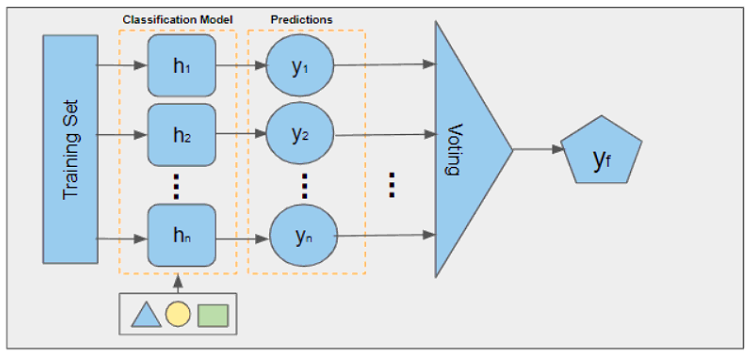

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor

In [ ]:
X_e = data[cols_to_use2]
y_e = data.specialTeamsResult_cat
X_e_train, X_e_test, y_e_train, y_e_test = train_test_split(X_e, y_e, test_size=0.4, random_state = 11)
X_e_dl_train, X_e_dl_valid, y_e_dl_train, y_e_dl_valid = train_test_split(X_e_train, y_e_train, test_size=0.2, random_state = 11)

In [ ]:
import keras
from keras import utils as np_utils

## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_dl_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:6]:\n', y_e_dl_train[0:6])
print('\ny_train.shape: ', y_e_dl_train.shape)
print('y_test.shape: ', y_e_dl_valid.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.np_utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_e_dl_train)
y_valid = label_encode(label_encoder, y_e_dl_valid)
y_test = label_encode(label_encoder, y_e_test)

print('\n\n## After convert')
print('y_train[0:6]:\n', y_train[0:6])
print('\ny_train.shape: ', y_train.shape)
print('y_valid.shape: ', y_valid.shape)
print('\ny_test.shape: ', y_e_test.shape)

In [ ]:
ori_label = label_decode(label_encoder, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def evaluate(model, X_e_train, X_e_test, y_e_train, y_e_test):
    y_test_pred = model.predict(X_e_test)
    y_train_pred = model.predict(X_e_train)

    print("TRAINIG RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_e_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_e_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_e_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    print("TESTING RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_e_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_e_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_e_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    print(classification_report(ori_label, y_test_pred, target_names=X_punt.specialTeamsResult.unique()))

In [ ]:
# Create 5 objects that represent our 4 models
rf = RandomForestClassifier(n_jobs=-1,n_estimators=500,warm_start=True,max_depth=6,min_samples_leaf=2,max_features='sqrt',verbose=0)
et = ExtraTreesClassifier(n_jobs=-1,n_estimators=500,max_depth=12,min_samples_leaf=2,verbose=0)
ada = AdaBoostClassifier(n_estimators=500,learning_rate=0.75)#0.75
gb = GradientBoostingClassifier(n_estimators=500,max_depth=5,min_samples_leaf=2,verbose=0)#5
svc = SVC(kernel='linear',C=0.025,probability=True)

In [ ]:
clf2 = VotingClassifier(estimators = [('rf',rf), ('et',et), ('ada', ada), ('gb',gb), ('svc',svc)], voting='soft') # construct the ensemble classifier ,('clf1',clf1),('clf3',clf3)

In [ ]:
clf2.fit(X_e_train, y_e_train) # training tar

In [ ]:
y_true, y_pred = y_e_train, clf2.predict (X_e_test)

In [ ]:
print('accuracy on the test set: ', accuracy_score(y_e_test, y_pred))

In [ ]:
print(classification_report(ori_label, y_pred, target_names=X_punt.specialTeamsResult.unique()))

In [ ]:
evaluate(clf2, X_e_train, X_e_test, y_e_train, ori_label)

# DNN

**DNN Architecture**

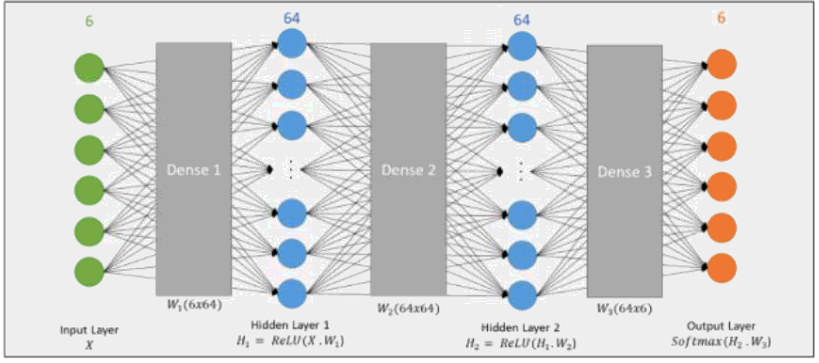

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

In [ ]:
X_dl_train

In [ ]:
# the histogram of the data
labels = X_dl_train['specialTeamsResult'].unique()
post_total = len(X_dl_train)
df1 = X_dl_train.groupby(['specialTeamsResult']).count()['specialTeamsResult_cat']
# df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(17,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('specialTeamsResult')
plt.title('specialTeamsResult distribution')
plt.grid(True)
plt.show()

In [ ]:
# the histogram of the data
labels = X_dl_valid['specialTeamsResult'].unique()
post_total = len(X_dl_valid)
df1 = X_dl_valid.groupby(['specialTeamsResult']).count()['specialTeamsResult_cat']
# df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(17,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('specialTeamsResult')
plt.title('specialTeamsResult distribution')
plt.grid(True)
plt.show()

In [ ]:
# the histogram of the data
labels = X5_test['specialTeamsResult'].unique()
post_total = len(X5_test)
df1 = X5_test.groupby(['specialTeamsResult']).count()['specialTeamsResult_cat']
# df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(17,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('specialTeamsResult')
plt.title('specialTeamsResult distribution')
plt.grid(True)
plt.show()

In [ ]:
## check dimension is a good habbit 
print('X_dl_train.shape: ', X_dl_train.shape)
print('y_dl_train.shape: ', y_dl_train.shape)
print('X_dl_valid.shape: ', X_dl_valid.shape)
print('y_dl_valid.shape: ', y_dl_valid.shape)

In [ ]:
import keras
from keras import utils as np_utils

## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_dl_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:6]:\n', y_dl_train[0:6])
print('\ny_train.shape: ', y_dl_train.shape)
print('y_test.shape: ', y_dl_valid.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.np_utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_dl_train)
y_valid = label_encode(label_encoder, y_dl_valid)
y_test = label_encode(label_encoder, y5_test)

print('\n\n## After convert')
print('y_train[0:6]:\n', y_train[0:6])
print('\ny_train.shape: ', y_train.shape)
print('y_valid.shape: ', y_valid.shape)
print('\ny_test.shape: ', y5_test.shape)


In [ ]:
X_train = X_dl_train[['yardlineNumber', 'kickLength', 'playResult', 'hangTime', 'snapDetail_cat', 'kickType_cat']]
X_valid = X_dl_valid[['yardlineNumber', 'kickLength', 'playResult', 'hangTime', 'snapDetail_cat', 'kickType_cat']]
X_test = X5_test[['yardlineNumber', 'kickLength', 'playResult', 'hangTime', 'snapDetail_cat', 'kickType_cat']]

input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 6
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 6
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

In [ ]:
from keras.callbacks import CSVLogger

# csv_logger = CSVLogger('logs/training_log.csv')

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=50, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.CSVLogger('./training_log_dnn_wo_gcn.csv'),
]

# training setting
epochs = 200
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[my_callbacks],
                    validation_data = (X_valid, y_valid))
print('training finish')

In [ ]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

In [ ]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

In [ ]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

In [ ]:
accuracy = accuracy_score(label_decode(label_encoder, y_test), pred_result, normalize=True)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
ori_label = label_decode(label_encoder, y_test)


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

print(classification_report(ori_label, pred_result, target_names=X_punt.specialTeamsResult.unique()))

print(confusion_matrix(ori_label, pred_result))

In [ ]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("./training_log_dnn_wo_gcn.csv")
training_log

In [ ]:
import plotly.express as px

training_log.plot(x="epoch", y=['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
training_log.plot(x="epoch", y=['loss', 'val_loss'])
plt.show()

# Social Network Features

* We are considering location dependencies as our additional features, which is related to social network
* The location dependencies among the players are model with a graph, which its vertex represent a player, and an edge that connect every two vertices that represents the distance between two player
* We used GCN to extract and aggregate the neighborhood information of each vertex
* And after that we concatenate the player embedding and the location dependency together, and fed it to the fully-connected NN to get the final embedding
* Therefore, the final embedding not only represent the information of the players but also that of its nearby neighbors.
* And we believe that the neighborhood information of particular player can help to improve our classification performance

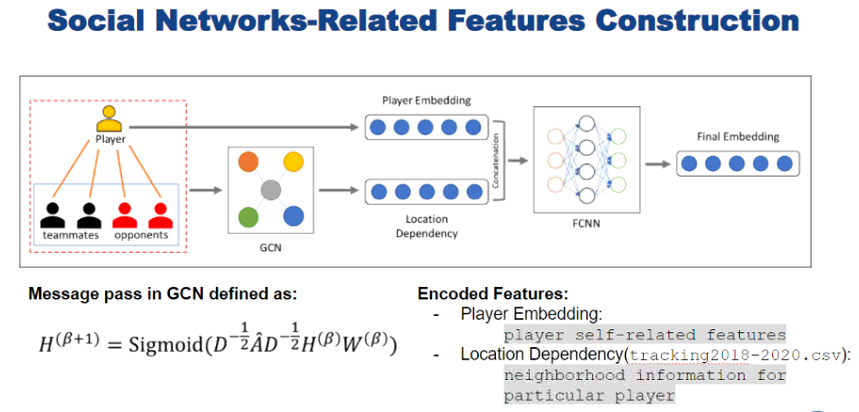

In [ ]:
# # this code is for extracting graph representation

# import math
# import networkx as nx
# import stellargraph as sg
# from stellargraph.mapper import FullBatchNodeGenerator
# from stellargraph.layer import GCN
# from tqdm import tqdm
# from sklearn import preprocessing, model_selection
# import tensorflow as tf
# from tensorflow.keras import layers, optimizers, losses, metrics, Model

# final_emb = []

# for index, row in tqdm(X_punt_ori.iterrows(), total=X_punt_ori.shape[0]):
    
#     tf.keras.backend.clear_session()
    
#     if (str(row['gameId'])[:4] == '2018'):
#         tracking_df = tracking2018_df
#     elif (str(row['gameId'])[:4] == '2019'):
#         tracking_df = tracking2019_df
#     else:
#         tracking_df = tracking2020_df
        
#     max_frame_id = max(tracking_df[(tracking_df['nflId'] == row['kickerId']) & (tracking_df['gameId'] == row['gameId'])
#                & (tracking_df['playId'] == row['playId'])]['frameId'].values[:])
#     team = tracking_df[(tracking_df['nflId'] == row['kickerId']) & (tracking_df['gameId'] == row['gameId'])
#                & (tracking_df['playId'] == row['playId'])  & (tracking_df['frameId'] == max_frame_id)]['team'].values[0]
#     temp = tracking_df[(tracking_df['gameId'] == row['gameId']) & (tracking_df['playId'] == row['playId'])
#                 & (tracking_df['frameId'] == max_frame_id) & (tracking_df['team'] == team)].copy()
#     temp2 = tracking_df[(tracking_df['gameId'] == row['gameId']) & (tracking_df['playId'] == row['playId'])
#                 & (tracking_df['frameId'] == max_frame_id) & (tracking_df['team'] != team)].copy()
    
#     df1 = pd.DataFrame()
    
#     for index1, row1 in temp.iterrows():
#         for index2, row2 in temp.iterrows():
#             if (row1['nflId'] != row2['nflId']):
#                 w_ = math.sqrt((row1['x'] - row2['x'])**2 + (row1['y'] - row2['y'])**2)
#                 df1 = df1.append({
#                     's': row1['nflId'],
#                     't': row2['nflId'],
#                     'weight': w_,
#                     'team': row1['team']
#                 }, ignore_index=True)
#         if (row1['nflId'] == row['kickerId']):
#             p_x = temp[temp['nflId'] == row['kickerId']]['x']
#             p_y = temp[temp['nflId'] == row['kickerId']]['y']
                
#     for index1, row1 in temp2.iterrows():
#         for index2, row2 in temp2.iterrows():
#             if (row1['nflId'] != row2['nflId']):
#                 w_ = math.sqrt((row1['x'] - row2['x'])**2 + (row1['y'] - row2['y'])**2)
#                 df1 = df1.append({
#                     's': row1['nflId'],
#                     't': row2['nflId'],
#                     'weight': w_,
#                     'team': row1['team']
#                 }, ignore_index=True)
        
#         w__ = math.sqrt((row1['x'] - p_x)**2 + (row1['y'] - p_y)**2)
#         df1 = df1.append({
#                     's': row['kickerId'],
#                     't': row2['nflId'],
#                     'weight': w__,
#                     'team': row2['team']
#                 }, ignore_index=True)

#     G=nx.from_pandas_edgelist(df1, 's', 't', ['weight'])
    
#     target_encoding = preprocessing.LabelBinarizer()
#     train_targets = target_encoding.fit_transform(np.concatenate((temp['team'], temp2['team'])))
#     labels = train_targets
    
#     n_classes = 2
    
#     gcn_model = GCNNetwork(
#         n_inputs=G.number_of_nodes(), 
#         n_outputs=n_classes, 
#         n_layers=2,
#         hidden_sizes=[16, 8], 
#         activation=np.tanh,
#         seed=100,
#     )
#     gcn_model
    
#     A = nx.to_numpy_matrix(G)
    
#     A_mod = A + np.eye(G.number_of_nodes()) # add self-connections

#     D_mod = np.zeros_like(A_mod)
#     np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis=1)).flatten())


#     D_mod_invroot = np.linalg.inv(sqrtm(D_mod))

#     A_hat = D_mod_invroot @ A_mod @ D_mod_invroot
    
#     X = np.eye(G.number_of_nodes())
    
# #     embed = gcn_model.embedding(A_hat, X)

#     train_nodes = np.array([0, 1, 8])
#     test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])
#     opt2 = GradDescentOptim(lr=2e-2, wd=2.5e-2)
    
#     embeds = list()
#     accs = list()
#     train_losses = list()
#     test_losses = list()

#     loss_min = 1e6
#     es_iters = 0
#     es_steps = 50
#     # lr_rate_ramp = 0 #-0.05
#     # lr_ramp_steps = 1000

#     for epoch in range(15000):

#         y_pred = gcn_model.forward(A_hat, X)

#         opt2(y_pred, labels, train_nodes)

#     #     if ((epoch+1) % lr_ramp_steps) == 0:
#     #         opt2.lr *= 1+lr_rate_ramp
#     #         print(f"LR set to {opt2.lr:.4f}")

#         for layer in reversed(gcn_model.layers):
#             layer.backward(opt2, update=True)

#         embeds.append(gcn_model.embedding(A_hat, X))
#         # Accuracy for non-training nodes
#         acc = (np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))[
#             [i for i in range(labels.shape[0]) if i not in train_nodes]
#         ]
#         accs.append(acc.mean())

#         loss = xent(y_pred, labels)
#         loss_train = loss[train_nodes].mean()
#         loss_test = loss[test_nodes].mean()

#         train_losses.append(loss_train)
#         test_losses.append(loss_test)

#         if loss_test < loss_min:
#             loss_min = loss_test
#             es_iters = 0
#         else:
#             es_iters += 1

#         if es_iters > es_steps:
# #             print("Early stopping!")
#             break

# #         if epoch % 100 == 0:
# #             print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")

#     train_losses = np.array(train_losses)
#     test_losses = np.array(test_losses)
    
#     all_nodes = list(G.nodes)
    
#     final_emb.append(embed[all_nodes.index(row['kickerId'])])

In [ ]:
final_emb_df = pd.read_csv('../input/graph-representation/final_emb_df.txt')
final_emb_df

In [ ]:
concatenated = pd.concat([data.copy().reset_index(), final_emb_df], axis = 1)
concatenated

In [ ]:
tmp = concatenated[['yardlineNumber', 'kickLength', 'playResult', 'hangTime', 'snapDetail_cat', 'kickType_cat',
               '0', '1', '2', '3', '4', '5', '6', '7']].copy()

### Conventional Methods with Social Networks Features

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


models = {
    "XGBClassifier": XGBClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),  
    "Stochastic Gradient Descent Classifier": SGDClassifier(),
    "Support Vector Classifier": SVC(),
    "Linear Support Vector Classifier": LinearSVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(random_state = 5)         
         }
 
cols_to_use2 = ['yardlineNumber', 'kickLength', 'playResult', 'hangTime', 'snapDetail_cat', 'kickType_cat',
               '0', '1', '2', '3', '4', '5', '6', '7']

X5 = concatenated[['specialTeamsResult', 'specialTeamsResult_cat', 'yardlineNumber',
           'kickLength', 'kickReturnYardage', 'playResult', 'absoluteYardlineNumber', 
           'snapDetail', 'snapDetail_cat', 'kickType', 'kickType_cat', 
           'kickContactType', 'kickContactType_cat', 'operationTime', 'hangTime',
            '0', '1', '2', '3', '4', '5', '6', '7']]
y5 = concatenated['specialTeamsResult_cat']

X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.4, random_state = 11)
X_dl_train, X_dl_valid, y_dl_train, y_dl_valid = train_test_split(X5_train, y5_train, test_size=0.2, random_state = 11)

for name, model in models.items():
    model.fit(X_dl_train[cols_to_use2], y_dl_train)
    print(name + " trained")
    
print("-------------------------", '\n')

for name, model in models.items():
    print(name)
    predictions4 = model.predict(X5_test[cols_to_use2])
    print("Accuracy: %.2f%%" % (accuracy_score(y5_test, predictions4, normalize=True) * 100.0))
    print(classification_report(y5_test, predictions4, target_names=X_punt.specialTeamsResult.unique()))

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

my_model5 = XGBClassifier(booster='gbtree', max_depth=7, eta=0.07, gamma=0.01, subsample=0.8, colsample_bytree = 1, min_child_weight=2)
my_model5.fit(X_dl_train[cols_to_use2], y_dl_train)

predictions5 = my_model5.predict(X5_test[cols_to_use2])

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y5_test, predictions5, normalize=True)
print("Primary Accuracy: 68.74% (with standart parameters)")
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print('\n')
print(my_model5)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

print(classification_report(y5_test, predictions5, target_names=X_punt.specialTeamsResult.unique()))

print(confusion_matrix(y5_test, predictions5))

plot_confusion_matrix(my_model5, X5_test[cols_to_use2], y5_test)  
plt.show()

### DNN with Social Networks Features

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
import keras
from keras import utils as np_utils

## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_dl_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:6]:\n', y_dl_train[0:6])
print('\ny_train.shape: ', y_dl_train.shape)
print('y_test.shape: ', y_dl_valid.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.np_utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_dl_train)
y_valid = label_encode(label_encoder, y_dl_valid)
y_test = label_encode(label_encoder, y5_test)

print('\n\n## After convert')
print('y_train[0:6]:\n', y_train[0:6])
print('\ny_train.shape: ', y_train.shape)
print('y_valid.shape: ', y_valid.shape)
print('\ny_test.shape: ', y5_test.shape)


In [ ]:
X_train = X_dl_train[['yardlineNumber', 'kickLength', 'playResult', 'hangTime', 'snapDetail_cat', 'kickType_cat', 
                      '0', '1', '2', '3', '4', '5', '6', '7']]
X_valid = X_dl_valid[['yardlineNumber', 'kickLength', 'playResult', 'hangTime', 'snapDetail_cat', 'kickType_cat', 
                      '0', '1', '2', '3', '4', '5', '6', '7']]
X_test = X5_test[['yardlineNumber', 'kickLength', 'playResult', 'hangTime', 'snapDetail_cat', 'kickType_cat', 
                  '0', '1', '2', '3', '4', '5', '6', '7']]

input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 14
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 6
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

In [ ]:
from keras.callbacks import CSVLogger

# csv_logger = CSVLogger('logs/training_log.csv')

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=50, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.CSVLogger('./training_log_w_gcn.csv'),
]

# training setting
epochs = 200
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[my_callbacks],
                    validation_data = (X_valid, y_valid))
print('training finish')

In [ ]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

In [ ]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

In [ ]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

In [ ]:
accuracy = accuracy_score(label_decode(label_encoder, y_test), pred_result, normalize=True)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
ori_label = label_decode(label_encoder, y_test)


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

print(classification_report(ori_label, pred_result, target_names=X_punt.specialTeamsResult.unique()))

print(confusion_matrix(ori_label, pred_result))

In [ ]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("./training_log_w_gcn.csv")
training_log

In [ ]:
import plotly.express as px

training_log.plot(x="epoch", y=['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
training_log.plot(x="epoch", y=['loss', 'val_loss'])
plt.show()